In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

## The R2D2 prior

Suppose we have a normal regression model:

$$
\begin{aligned}
Y_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} = \alpha + \boldsymbol{X}\boldsymbol{\beta}
\end{aligned}
$$

where $\boldsymbol{X}$ is the $n \times p$ design matrix (without the intercept) and $\boldsymbol{\beta}$, of length $p$, is the vector of coefficients.

The R2D2 prior model is:

$$
\begin{aligned}
\beta_j &\sim \text{Normal}(0, \phi_j W \sigma^2) \\
\boldsymbol{\phi} &\sim \text{Dirichlet}(\xi_1, \dots, \xi_p) \\
W & = \frac{R^2}{1 - R^2}\\
R^2 &\sim \text{Beta}(a, b) \\
\end{aligned}
$$

Different authors write $R^2$ using slightly different formulas,
but in all cases it represents the ratio of the marginal variance of the linear predictor to the marginal variance of the outcome:

$$
R^2 = \frac{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta})}{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
= \frac{\sigma^2 W}{\sigma^2 W + \sigma^2} 
= \frac{W}{W + 1}
$$

The R2D2 prior belongs to the family of global-local shrinkage priors. 
Its key feature is that it places a prior directly on the interpretable quantity $R^2$, the coefficient of determination.
Through the transformation $W = R^2/(1-R^2)$, this induces a prior on $W$, which governs the total prior variance of the linear predictor.
The authors of the R2D2 priorshow that the induced prior on $W$ is a Beta Prime distribution with parameters $a$ and $b$.

### A simulated example in PyMC

In [2]:
rng = np.random.default_rng(1234)

TRUE_ALPHA = 2
TRUE_BETAS = pm.draw(
    pm.Normal.dist(
        mu=[0] * 40 + [2] * 3 + [-2] * 3,
        sigma=[0.2] * 40 + [0.5] * 6
    ),
    random_seed=rng
)
TRUE_SIGMA = 3

n = 2000
p = len(TRUE_BETAS)

X = pm.draw(pm.Uniform.dist(lower=-2, upper=2, shape=p), draws=n)
X_std = X / X.std(0)
y = pm.draw(pm.Normal.dist(mu=TRUE_ALPHA + X_std @ TRUE_BETAS, sigma=TRUE_SIGMA))

$$
\text{Var}(\boldsymbol{X}^T \boldsymbol{\beta}) = \boldsymbol{\beta}^T \text{Cov}(\boldsymbol{X}) \boldsymbol{\beta} = \boldsymbol{\beta}^T  \Sigma_x  \boldsymbol{\beta}
$$

In [3]:
# Theoretical R^2
Sigma = np.eye(p)
TRUE_R2 = (TRUE_BETAS.T @ Sigma @ TRUE_BETAS) / ((TRUE_BETAS.T @ Sigma @ TRUE_BETAS) + TRUE_SIGMA ** 2)
TRUE_R2

np.float64(0.6620672162995033)

In [4]:
# Scikit learn R^2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_std, y)
y_pred = model.predict(X_std)
r2_score(y, y_pred)

0.6538505629162559

In [5]:
# "Significant" R^2
TRUE_BETAS_S = TRUE_BETAS.copy()
TRUE_BETAS_S[:-6] = 0
TRUE_BETAS_S

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.47491203,  1.57896255,  1.25458358, -1.37604513, -1.47790265,
       -1.35262706])

In [6]:
mu_var =  (TRUE_BETAS_S.T @ Sigma @ TRUE_BETAS_S)
mu_var / (mu_var + TRUE_SIGMA ** 2) # does not make sense either

np.float64(0.6414283863553738)

(Gamma(alpha=51.3, beta=5.69), <Axes: >)

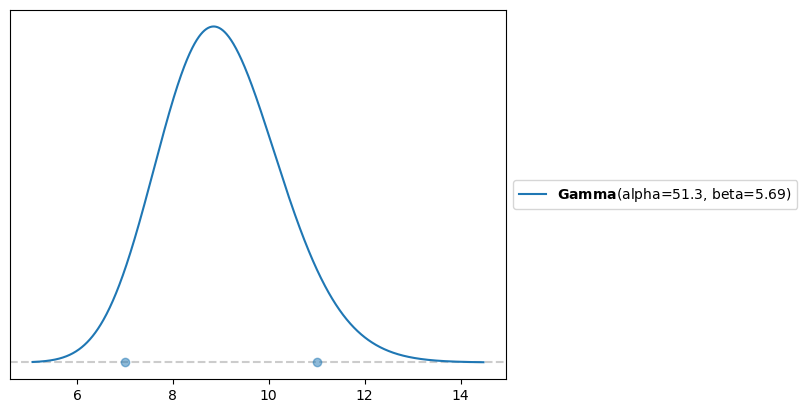

In [7]:
pz.maxent(pz.Gamma(), lower=7, upper=11)

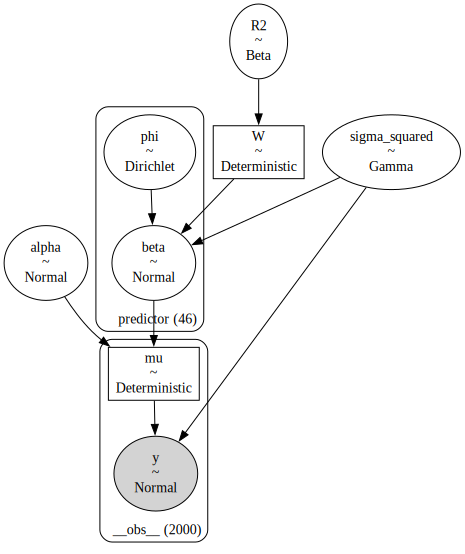

In [8]:
coords = {
    "predictor": np.arange(p),
    "__obs__": np.arange(n)
}

with pm.Model(coords=coords) as model_1:
    sigma_squared = pm.Gamma("sigma_squared", alpha=51.3, beta=5.69)
    
    phi = pm.Dirichlet("phi", a=np.ones(p), dims="predictor")
    R2 = pm.Beta("R2", alpha=1, beta=1)
    W = pm.Deterministic("W", R2 / (1 - R2))

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta", sigma=(phi * W * sigma_squared) ** 0.5, dims="predictor")
    mu = pm.Deterministic("mu", alpha + X_std @ beta, dims="__obs__")

    pm.Normal("y", mu=mu, sigma=sigma_squared ** 0.5, observed=y, dims="__obs__")

model_1.to_graphviz()

In [9]:
with model_1:
    idata_1 = pm.sample(draws=1000, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_squared, phi, R2, alpha, beta]


Output()

/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


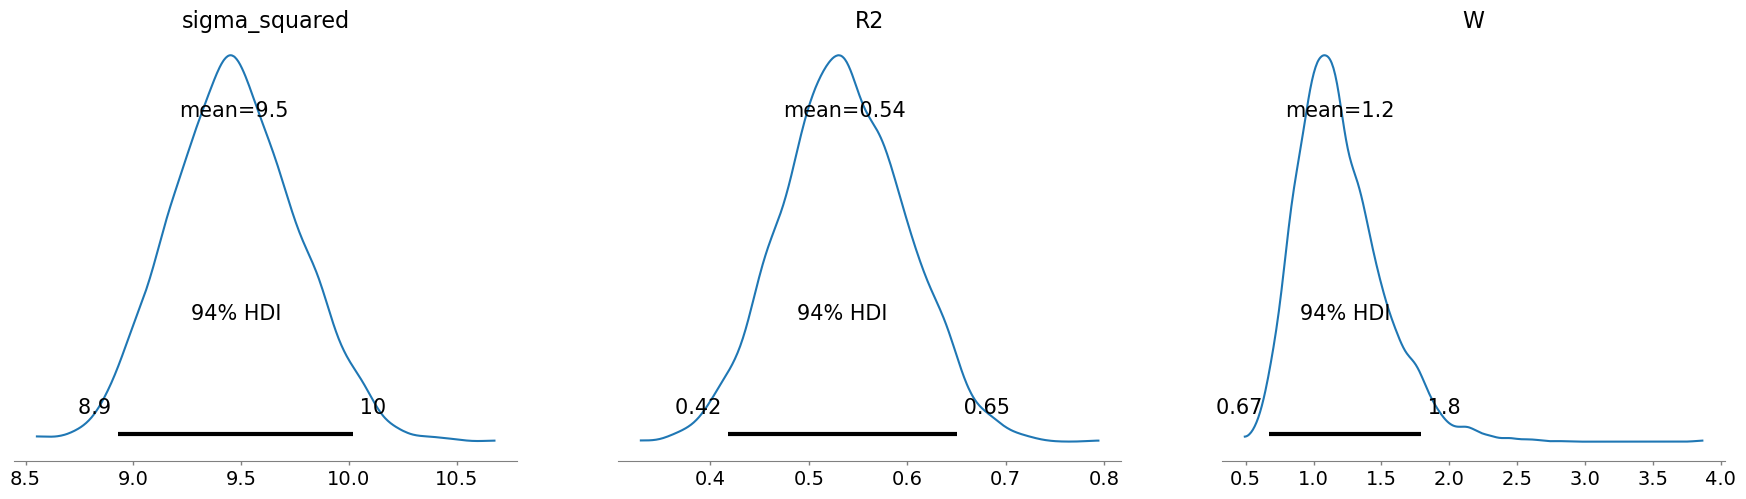

In [10]:
az.plot_posterior(idata_1, var_names=["sigma_squared", "R2", "W"]);

In [11]:
with model_1:
    idata_1.extend(pm.sample_posterior_predictive(idata_1))

Sampling: [y]


Output()

Let's try to compute R^2 using Gelman's paper.

$$
R^2 = \frac{\text{Explained variance}}{\text{Explained variance} + \text{Residual variance}} = \frac{\text{var}_\text{fit}}{\text{var}_\text{fit} + \text{var}_\text{res}}
$$

* $\text{var}_\text{fit} = V_{n=1}^N E(\tilde{y}_n \mid \theta)$
* $\text{var}_\text{res} = E(V_{n=1}^N(\tilde{y}_n - y_n^\text{pred} \mid \theta))$

In [12]:
var_fit = idata_1.posterior["mu"].mean(("chain", "draw")).var().item()
var_res = idata_1.posterior["sigma_squared"].mean().item()
var_fit / (var_fit + var_res)

0.6433054550402012

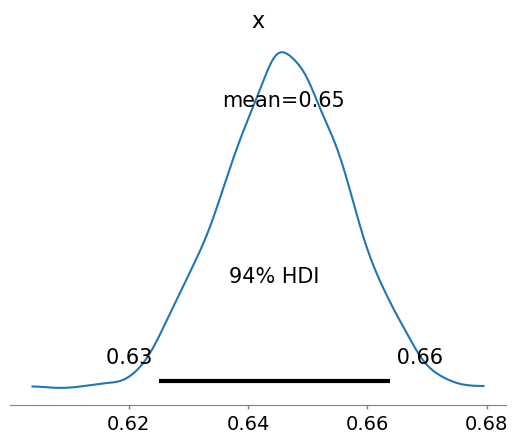

In [13]:
r2_posterior = (idata_1.posterior["mu"].var("__obs__") / (idata_1.posterior["mu"].var("__obs__") + idata_1.posterior["sigma_squared"]))
az.plot_posterior(r2_posterior);

whaaaat!

This _does match_ the _theoretical_ $R^2$... why don't we see that in our posterior? Are we mixing different $R^2$ definitions?

To Do: Put the prior using the GBP approach and see what we get...